# Image Segmentation - Part 1: Thresholding

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) is the process of partitioning sets of image pixels into groups (e.g. foreground and background). In this module we will explore different image segmentation approaches, including thresholding, edge detection, clustering, and machine learning.

In [1]:
%matplotlib widget
import matplotlib
from plantcv import plantcv as pcv

In [2]:
# Global settings
matplotlib.rcParams["figure.max_open_warning"] = False
pcv.params.debug = "plot"
pcv.params.text_size = 30
pcv.params.text_thickness = 20
pcv.params.line_thickness = 10

In [3]:
pcv.__version__

'4.7.dev111+g0aac934c.d20250401'

## 01. Preparing the image for thresholding

The goal of this section is to read in the color image, identify a grayscale component of the image that maximizes the gray value difference between the plants and the background.

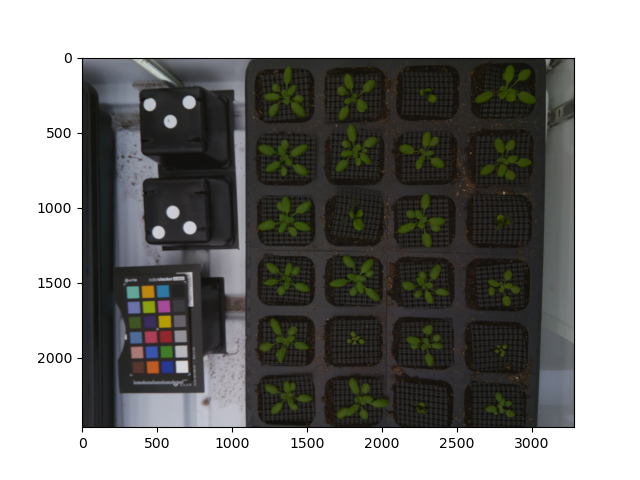

In [4]:
# Open image file
color_img, imgpath, imgname = pcv.readimage(filename="./images/10.9.1.230_pos-165-001-004_2019-11-01-10-05.jpg")

`pcv.visualize.colorspaces` is a visualization tool that converts the color (RGB) image into the Hue, Saturation, and Value (HSV) and CIELAB (L = lightness, A = green-magenta, B = blue-yellow) colorspaces and displays the individual channels as grayscale images. We are aiming to identify the grayscale image that maximizes the gray value difference between the plants and the background.

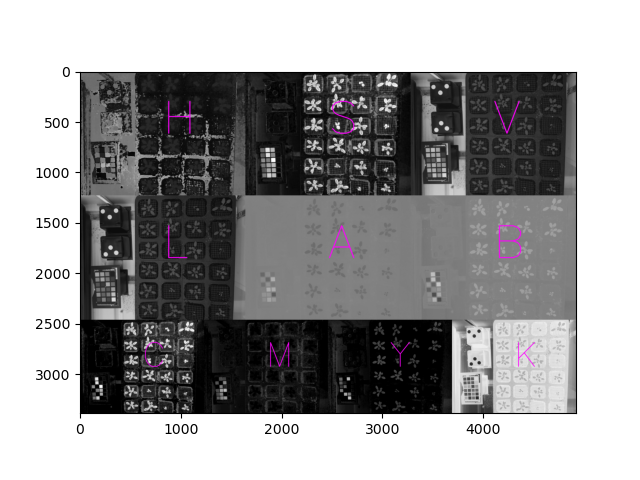

In [5]:
# Visualize component HSV and LAB color spaces
cs = pcv.visualize.colorspaces(rgb_img=color_img, original_img=False)

The "A" channel of LAB is a good choice, the plants are dark and the background is light

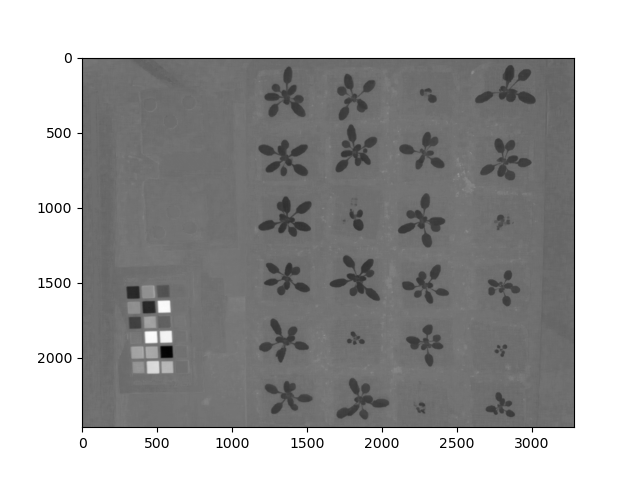

In [6]:
# Convert the RGB image into a grayscale image by choosing one of the HSV or LAB channels
grayscale_img = pcv.rgb2gray_lab(rgb_img=color_img, channel="a")

Next we will plot a histogram of the grayscale values of the "A" channel image. The background occupies the majority of pixels in the image and these pixels are in the large peak centered at ~130. The plants have darker, lower values and are in the smaller peak centered at ~112. Using the `%matplotlib widget` tool in this notebook, you can use your mouse cursor to explore the image values in the plot above, and the histogram values in the graph below.

In [7]:
# Visualize a histogram of the grayscale values to identify signal related to the plant and the background
hist = pcv.visualize.histogram(img=grayscale_img, bins=30)

alt.Chart(...)

## 02. Segment the image using thresholding techniques

In this section we will utilize several different thresholding techniques to segment the image into plant (mostly) and background pixels. The result of thresholding is a binary mask. Each binary mask will have two values, 0 = black and 255 = white. Binary masks are used to label the foreground and background pixels and are required for analysis functions in PlantCV.

**Note**: The masks in this tutorial will still contain some background pixels (false positives). These false positives can be removed with additional filtering steps covered in other tutorials.

### 02a. Manually set a binary threshold

A binary threshold splits a one-dimensional series (in this case, grayscale values) into two ranges at a specified value. The pixels matching the range of values below the threshold are set to zero (black) and the values above are set to the maximum value (255, white) (`object_type="light"`). The logic of a binary threshold can also be inversed to set the upper range to 0 and the lower range to 255 (`object_type="dark"`.

Using the histogram above, we can determine a reasonable threshold value by identifying a grayscale value at the minimum between the two peaks. This is the ideal situation, in practice there can be more than two peaks or the peaks may overlap and it can be difficult to set a threshold.

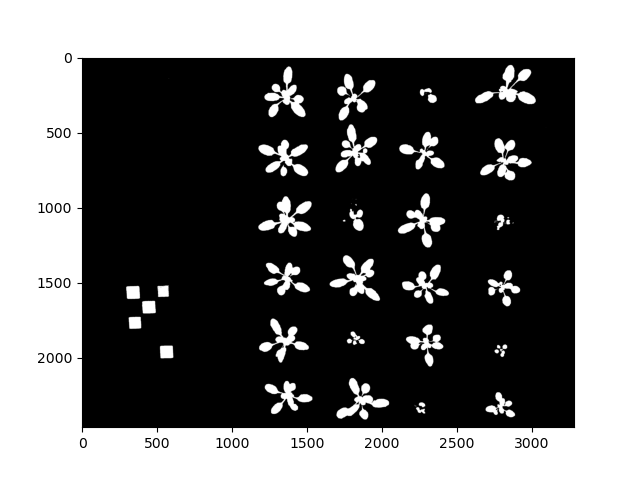

In [8]:
# Use the histogram to set a binary threshold where the plant pixels will be labeled white and the background will be labeled black
set_thresh = pcv.threshold.binary(gray_img=grayscale_img, threshold=120, object_type="dark")

### 02b. Automatically set a binary threshold

The `pcv.threshold.binary` method requires the user to choose the threshold value. In some cases, this global threshold value can be chosen automatically using [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method).

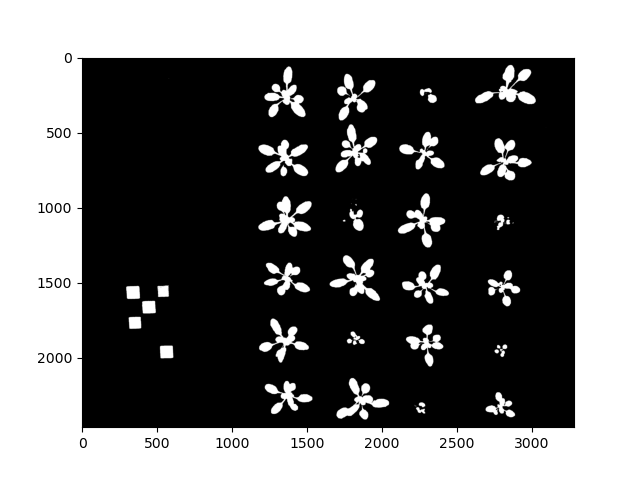

In [9]:
# Instead of setting a manual threshold, try an automatic threshold method such as Otsu
auto_thresh = pcv.threshold.otsu(gray_img=grayscale_img, object_type="dark")

### 02c. Adaptive thresholding

In the above examples, we set a global threshold that was applied uniformly to all pixels in the grayscale image. But in addition to pixel values, images contain spatial information. Adaptive thresholding techniques apply a threshold locally. A small square region (kernel) is scanned across the image at each pixel. A function is applied to calculate a summary measurement for the region (e.g. mean value) and the threshold is applied to the center pixel based on a set offset from the regional value. In the example below, the local threshold is the mean value of a 100x100 px region minus 3.

While not necessary for this example, adaptive thresholds can be useful under conditions of non-uniform illumination.

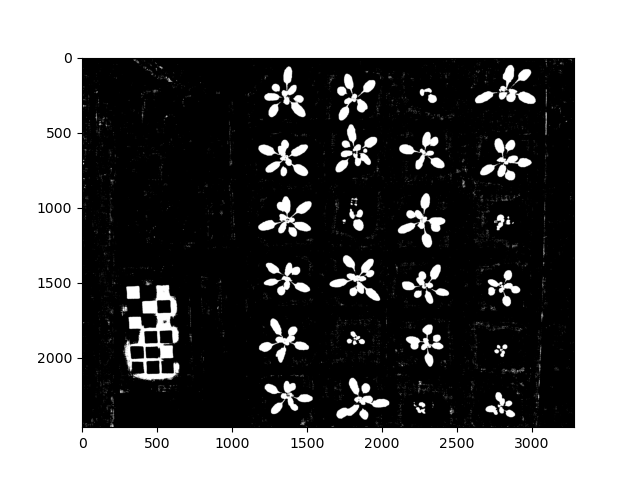

In [10]:
# Apply a threshold within local subregions of the image rather than globally
adapt_thresh = pcv.threshold.mean(gray_img=grayscale_img, ksize=100, offset=3, object_type="dark")

### 02d. Threshold ranges

The threshold methods above bisect a range of grayscale values. In cases where you want to isolate the range of values under a peak in the grayscale histogram, you can set a lower and upper threshold. Pixels matching values within the range are set to 255 (white) and outside the range to 0 (black). 

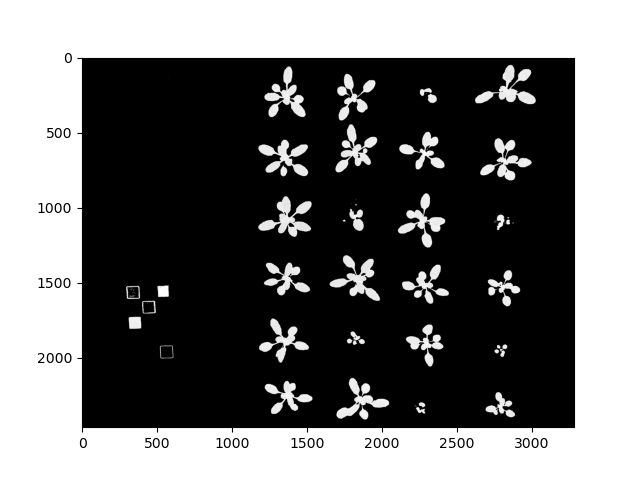

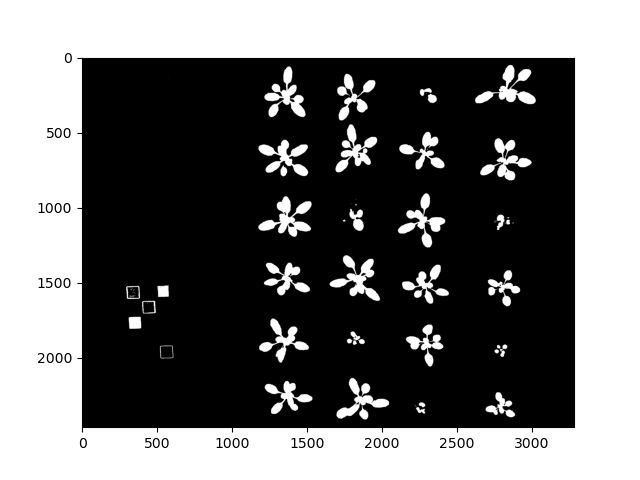

In [11]:
range_thresh = pcv.threshold.custom_range(img=grayscale_img, lower_thresh=[106], upper_thresh=[120], channel="gray")

### 02e. 3D threshold in RGB colorspace

Using the same method, you can directly segment a color (RGB) image by selecting a 3D bounding region in color space.

In [12]:
# Visualize a histogram of the RGB values to identify signal related to the plant and the background
rgb_hist = pcv.visualize.histogram(img=color_img, bins=30)

alt.Chart(...)

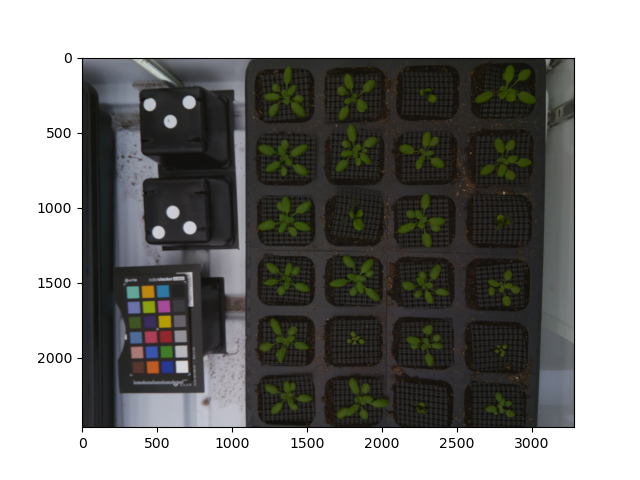

In [13]:
# Plot the input image for selecting RGB values
pcv.plot_image(color_img)

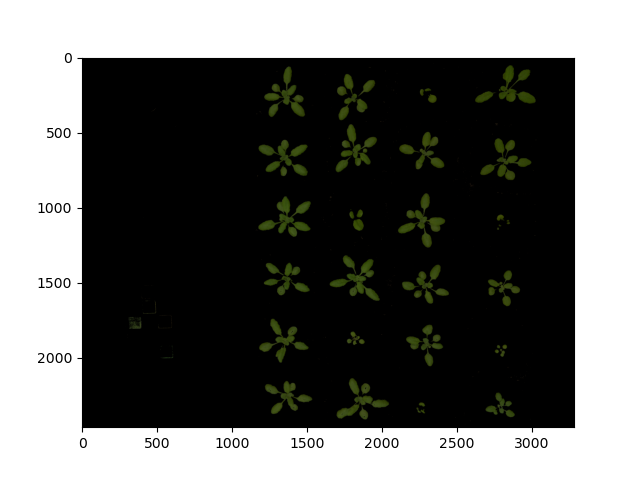

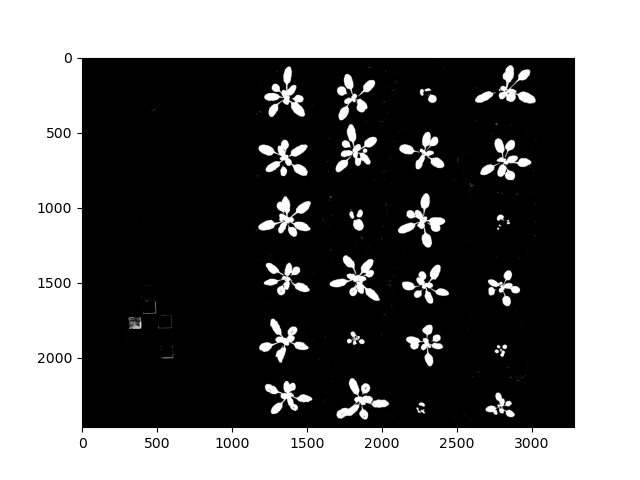

In [14]:
# Use the custom_range threshold to segment colors in 3D RGB colorspace
rgb_thresh, _ = pcv.threshold.custom_range(img=color_img, lower_thresh=[40, 50, 0], upper_thresh=[75, 95, 35], channel="rgb")